In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql

sys.path.append("..")
import analysislib as alib

In [3]:
sq = lambda q: pdsql.sqldf(q, globals())

In [4]:
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

In [18]:
processes = pd.read_csv("../../data/2025-03-11-time-14-55-15-third-run-process-scaling/master.csv", index_col=0)
limmem = pd.read_csv("../../data/2025-03-18-time-18-39-31-third-run-limmem/master.csv", index_col=0)
ramdisk = pd.concat([
            pd.read_csv("../../data/2025-03-12-time-17-06-39-ramdisk/master.csv", index_col=0),
            pd.read_csv("../../data/2025-03-04-time-18-40-26-second-run-finch2/master.csv", index_col=0)
])

In [8]:
ramdisk.head()

,cbSize,cioengine,ciodepth,crw,cnproc,cdevice,cdirect,cmemlim,readBW_bytes,readBW,...,writeBW,avgreadlat_ns,avgreadlat,avgwritelat_ns,avgwritelat,USR_UTIL_perc,SYS_UTIL_perc,IOW_UTIL_perc,IDL_UTIL_perc,CPU_UTIL_perc
0,4096,io_uring,128,randread,1,ram,0,none,1801674708,1.7 GB,...,0.0 B,290705.622000,290.7 µs,0.0,0.0 ns,0.488333,0.708889,0.000000,98.8056,1.19444
1,4096,io_uring,64,randread,1,ram,0,none,1811076236,1.7 GB,...,0.0 B,144447.843502,144.4 µs,0.0,0.0 ns,0.536667,0.695000,0.000556,98.7694,1.23056
2,4096,libaio,128,randread,1,ram,0,none,1600509519,1.5 GB,...,0.0 B,327264.070577,327.3 µs,0.0,0.0 ns,0.528000,0.717500,0.002500,98.7545,1.24550
3,4096,libaio,64,randread,1,ram,0,none,1575195450,1.5 GB,...,0.0 B,166107.423581,166.1 µs,0.0,0.0 ns,0.607143,0.718095,0.000000,98.6752,1.32476
4,4096,mmap,1,randread,1,ram,0,none,3097983803,2.9 GB,...,0.0 B,846.695422,846.7 ns,0.0,0.0 ns,1.313640,0.160909,0.000000,98.5264,1.47364


In [9]:
print(open("../../data/2025-03-11-time-14-55-15-third-run-process-scaling/fio-config.txt").read())

Total file size during runs: 34359738368
Block sizes: 4096
Numbers of processes: 32 48 64 72 84 96
Read/write type options: read write rw randread randwrite randrw
Async I/O engines: 
Async I/O depths: 
Sync I/O engines: sync mmap



In [11]:
print(open("../../data/2025-03-18-time-18-39-31-third-run-limmem/fio-config.txt").read())

Total file size during runs: 34359738368
Block sizes: 4096
Numbers of processes: 64
Read/write type options: read write rw randread randwrite randrw
Sync I/O engines: mmap
Cgrouped memory limits: 64M 128M 256M 512M 1G 2G 4G 8G 16G 32G 64G
Options for DIRECT: 0 1



# Process scaling

In [12]:
sq("""
    SELECT cnproc, cdevice, readBW, writeBW, USR_UTIL_perc, SYS_UTIL_perc, IOW_UTIL_perc, IDL_UTIL_perc, CPU_UTIL_perc 
    FROM processes
    WHERE crw='read' AND cioengine='mmap'
    ORDER BY cdevice, cnproc
""")

,cnproc,cdevice,readBW,writeBW,USR_UTIL_perc,SYS_UTIL_perc,IOW_UTIL_perc,IDL_UTIL_perc,CPU_UTIL_perc
0,32,ssd,4.8 GB,0.0 B,1.98833,1.46667,24.4967,72.040,27.960
1,48,ssd,5.6 GB,0.0 B,2.01800,1.86400,34.6200,61.496,38.504
2,64,ssd,4.8 GB,0.0 B,2.60833,2.44000,41.5600,53.395,46.605
3,72,ssd,5.0 GB,0.0 B,2.56800,2.13600,40.7360,54.548,45.452
4,84,ssd,5.1 GB,0.0 B,2.31200,2.13800,38.5240,57.020,42.980
5,96,ssd,5.0 GB,0.0 B,2.03600,2.08400,38.2140,57.666,42.334
6,32,zram,20.2 GB,0.0 B,7.84000,15.76000,0.0000,76.370,23.630
7,48,zram,19.1 GB,0.0 B,14.93000,21.13000,0.0000,63.940,36.060
8,64,zram,17.9 GB,0.0 B,10.77000,26.49000,0.0000,62.740,37.260
9,72,zram,18.7 GB,0.0 B,8.87000,26.85000,0.0000,64.270,35.730


In [13]:
sq("""
    SELECT cnproc, cdevice, readBW, writeBW, USR_UTIL_perc, SYS_UTIL_perc, IOW_UTIL_perc, IDL_UTIL_perc, CPU_UTIL_perc 
    FROM processes
    WHERE crw='read' AND cioengine='sync'
    ORDER BY cdevice, cnproc
""")

,cnproc,cdevice,readBW,writeBW,USR_UTIL_perc,SYS_UTIL_perc,IOW_UTIL_perc,IDL_UTIL_perc,CPU_UTIL_perc
0,32,ssd,1.5 GB,0.0 B,0.581500,1.37350,25.666500,72.3620,27.63800
1,48,ssd,2.0 GB,0.0 B,0.604286,3.09036,18.885700,77.4157,22.58430
2,64,ssd,2.5 GB,0.0 B,1.578330,5.20750,40.492500,52.7042,47.29580
3,72,ssd,2.6 GB,0.0 B,0.842000,6.24733,27.816700,65.0913,34.90870
4,84,ssd,2.7 GB,0.0 B,0.938750,7.62125,23.334400,68.1069,31.89310
5,96,ssd,2.9 GB,0.0 B,1.257140,8.20929,23.476400,67.0550,32.94500
6,32,zram,9.0 GB,0.0 B,3.615000,22.92000,0.000000,73.4300,26.57000
7,48,zram,8.3 GB,0.0 B,0.850870,5.83783,0.003043,93.2283,6.77174
8,64,zram,9.5 GB,0.0 B,3.155000,37.43500,0.005000,59.3950,40.60500
9,72,zram,6.8 GB,0.0 B,1.688180,16.17270,0.009091,82.1291,17.87090


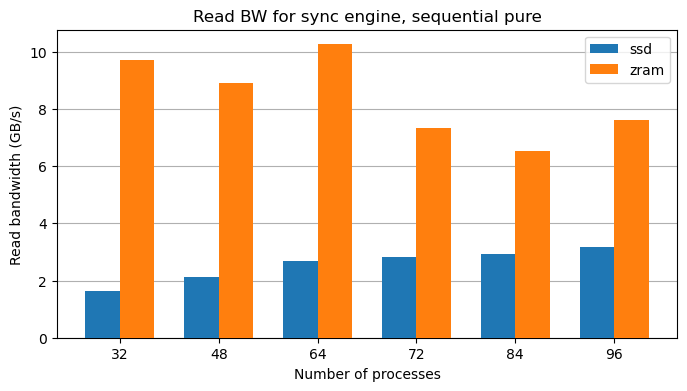

In [15]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM processes"), 
    np.array(sqflat("SELECT readBW_bytes FROM processes WHERE crw='read' AND cioengine='sync' ORDER BY cdevice, cnproc"))/10**9,
    labels=sqflat("SELECT DISTINCT cdevice FROM processes"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    title="Read BW for sync engine, sequential pure",
    show=False
)
plt.savefig("../../processed-data/2025-03-13-process-scaling/read-sync-seq.png")

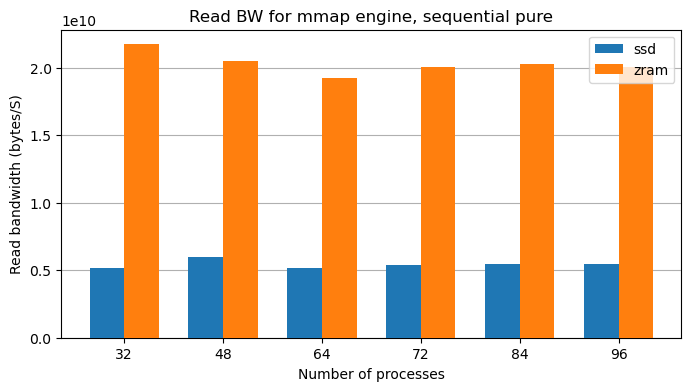

In [17]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM processes"), 
    sqflat("SELECT readBW_bytes FROM processes WHERE crw='read' AND cioengine='mmap' ORDER BY cdevice, cnproc"),
    labels=sqflat("SELECT DISTINCT cdevice FROM processes"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (bytes/S)",
    title="Read BW for mmap engine, sequential pure",
    show=False
)
plt.savefig("../../processed-data/2025-03-13-process-scaling/read-mmap-seq.png")

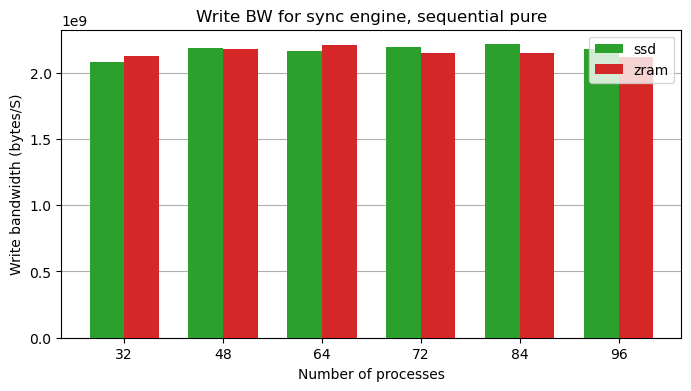

In [21]:

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM processes"), 
    sqflat("SELECT writeBW_bytes FROM processes WHERE crw='write' AND cioengine='sync' ORDER BY cdevice, cnproc"),
    labels=sqflat("SELECT DISTINCT cdevice FROM processes"),
    xlabel="Number of processes",
    ylabel="Write bandwidth (bytes/S)",
    title="Write BW for sync engine, sequential pure",
    colors=alib.default_colors[2:],
    show=False
)
plt.savefig("../../processed-data/2025-03-13-process-scaling/write-sync-seq.png")

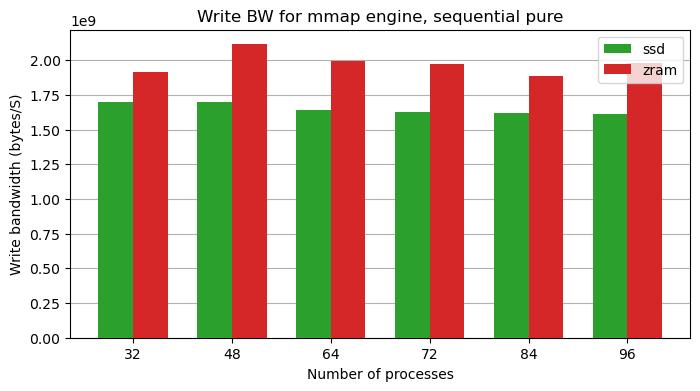

In [22]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM processes"), 
    sqflat("SELECT writeBW_bytes FROM processes WHERE crw='write' AND cioengine='mmap' ORDER BY cdevice, cnproc"),
    labels=sqflat("SELECT DISTINCT cdevice FROM processes"),
    xlabel="Number of processes",
    ylabel="Write bandwidth (bytes/S)",
    title="Write BW for mmap engine, sequential pure",
    colors=alib.default_colors[2:],
    show=False
)
plt.savefig("../../processed-data/2025-03-13-process-scaling/write-mmap-seq.png")

# Limited memory

In [19]:
#limmem = pd.read_csv("../../data/2025-03-11-time-21-44-10-third-run-limmem/master.csv")
limmem = pd.read_csv("../../data/2025-03-18-time-18-39-31-third-run-limmem/master.csv")


In [20]:
limmem.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cmemlim_bytes', 'cfile',
       'readBW_bytes', 'readBW', 'writeBW_bytes', 'writeBW', 'avgreadlat_ns',
       'avgreadlat', 'avgwritelat_ns', 'avgwritelat', 'USR_UTIL_perc',
       'SYS_UTIL_perc', 'IOW_UTIL_perc', 'IDL_UTIL_perc', 'CPU_UTIL_perc',
       'diskutil-TOTAL_READS(KB)', 'diskutil-TOTAL_WRITES(KB)',
       'diskutil-TOTAL_READS(MB)', 'diskutil-TOTAL_WRITES(MB)',
       'diskutil-TOTAL_READS(GB)', 'diskutil-TOTAL_WRITES(GB)',
       'diskutil-rMB/s', 'diskutil-wMB/s', 'diskutil-AVGRQ-SZ',
       'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

In [29]:
print("Read B/W for random reads:")
sq("""
    SELECT cmemlim, cdevice, readBW, `diskutil-rMB/s`
    FROM limmem
    WHERE crw='read' AND cdirect=0
    ORDER BY cdevice, cmemlim_bytes
""")

Read B/W for random reads:


,cmemlim,cdevice,readBW,diskutil-rMB/s
0,64M,ssd,4.1 GB,3795.42
1,128M,ssd,4.7 GB,4084.76
2,256M,ssd,4.8 GB,4080.05
3,512M,ssd,4.8 GB,4081.35
4,1G,ssd,4.6 GB,4075.01
5,2G,ssd,4.8 GB,4080.83
6,4G,ssd,4.8 GB,4064.28
7,8G,ssd,4.8 GB,4076.16
8,16G,ssd,4.8 GB,4088.38
9,32G,ssd,4.8 GB,4069.21


In [23]:
sq("""
    SELECT cmemlim, cdevice, writeBW, `diskutil-wMB/s`
    FROM limmem
    WHERE crw='write' AND cdirect=1
    ORDER BY cdevice, cmemlim_bytes
""")

,cmemlim,cdevice,writeBW,diskutil-wMB/s
0,128M,ssd,1.8 GB,1724.6200
1,256M,ssd,1.8 GB,1739.7800
2,512M,ssd,1.9 GB,1762.7900
3,1G,ssd,1.9 GB,1772.7100
4,2G,ssd,1.9 GB,1765.8000
5,4G,ssd,1.9 GB,1758.8600
6,8G,ssd,1.9 GB,1780.7100
7,16G,ssd,1.9 GB,1763.5600
8,32G,ssd,1.9 GB,1766.5000
9,64G,ssd,1.8 GB,1734.8900


# Ramdisk

In [ ]:
ramdisk.columns

In [ ]:
sq("""
    SELECT crw, cdevice, readBW, writeBW
    FROM ramdisk
    WHERE cioengine="sync" AND cnproc=64
    ORDER BY cdevice, crw
""")

In [ ]:
# Generic graph function (again outputted by chatgpt but modified by me to be generic)
def graph_output(df, metric, ylabel, title, path, bar_colors=None):
    # Group the data by 'crw' and 'cdevice' and take the mean of the specified metric
    grouped_data = df.groupby(['crw', 'cdevice'])[metric].mean().unstack()

    # Set up the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the positions for the bars on the x-axis
    positions = np.arange(len(grouped_data))

    # Set the bar width
    bar_width = 0.2

    # Default colors for 'ssd' and 'zram'
    if bar_colors is None:
        bar_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # default: blue for SSD, orange for ZRAM

    # Plot the bars for each cdevice (ssd and zram) with the specified colors
    ax.bar(positions - bar_width, grouped_data['ssd'], width=bar_width, label='SSD', align='center', color=bar_colors[0])
    ax.bar(positions, grouped_data['zram'], width=bar_width, label='ZRAM', align='center', color=bar_colors[1])
    ax.bar(positions + bar_width, grouped_data['ram'], width=bar_width, label='RAM', align='center', color=bar_colors[2])

    # Set the x-axis labels (crw types)
    ax.set_xticks(positions)
    ax.set_xticklabels(grouped_data.index, rotation=45)

    # Set labels and title
    ax.set_xlabel('crw Type')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Add a legend
    ax.legend(title='Device')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot as a file
    plt.savefig(path)

    # Show the plot
    plt.show()

In [ ]:
import matplotlib as mpl
mpl.rc('font', family='Arial') 
mpl.rcParams.update({'font.size': 20})

In [ ]:
import os
outDir = "../../processed-data/2025-03-13-ramdisk/"
os.makedirs(f"{outDir}/graphs/readBW", exist_ok=True)
os.makedirs(f"{outDir}/graphs/writeBW", exist_ok=True)
os.makedirs(f"{outDir}/graphs/readlat", exist_ok=True)
os.makedirs(f"{outDir}/graphs/writelat", exist_ok=True)

params = "crw, cdevice, readBW_bytes, writeBW_bytes, avgreadlat_ns, avgwritelat_ns"

In [ ]:
for ioengine in ["io_uring", "libaio", "sync",  "mmap"]:

     query = """
          SELECT {}
          FROM ramdisk
          WHERE cioengine='{}' AND cnproc='64' {}
     """
     df = sq(query.format(params, ioengine, "AND ciodepth='128'" if ioengine in ["io_uring", "libaio"] else ""))
     df["readBW_GB"] = df["readBW_bytes"]/(1024.0 * 1024.0 * 1024.0)
     df["writeBW_GB"] = df["writeBW_bytes"]/(1024.0 * 1024.0 * 1024.0)

     prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

     graph_output(df, "readBW_GB", "Read bandwidth (GB/s)", f"Read BW for max resource {ioengine}", f"{outDir}/graphs/readBW/max-{ioengine}.png")
     graph_output(df, "writeBW_GB", "Write bandwidth (GB/s)", f"Write BW for max resource {ioengine}", f"{outDir}/graphs/writeBW/max-{ioengine}.png", prop_cycle[3:])
     graph_output(df, "avgreadlat_ns", "Average read latency (ns)", f"Read lat for max resource {ioengine}", f"{outDir}/graphs/readlat/max-{ioengine}.png", prop_cycle[0:])
     graph_output(df, "avgwritelat_ns", "Average read latency (ns)", f"Write lat for max resource {ioengine}", f"{outDir}/graphs/writelat/max-{ioengine}.png", prop_cycle[3:])

In [7]:
ramdisk.columns

Index(['cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc', 'cdevice',
       'cdirect', 'cmemlim', 'readBW_bytes', 'readBW', 'writeBW_bytes',
       'writeBW', 'avgreadlat_ns', 'avgreadlat', 'avgwritelat_ns',
       'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc', 'IOW_UTIL_perc',
       'IDL_UTIL_perc', 'CPU_UTIL_perc'],
      dtype='object')

In [11]:
sq("""
    SELECT cdevice, SYS_UTIL_perc, IOW_UTIL_perc, IDL_UTIL_perc, CPU_UTIL_perc
    FROM ramdisk
    WHERE crw="read" AND cnproc=64 AND cioengine="mmap"
    ORDER BY cdevice
""")

,cdevice,SYS_UTIL_perc,IOW_UTIL_perc,IDL_UTIL_perc,CPU_UTIL_perc
0,ram,NaN,NaN,NaN,NaN
1,ssd,2.1175,38.65,55.7575,44.2425
2,zram,25.7000,0.00,63.2000,36.8000
